In [6]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

from pathlib import Path
import os

GRAPHS_PATH = Path(os.getcwd()).resolve().parent.parent.joinpath("data", "graphs","ch_17")
GRAPHS_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = GRAPHS_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [1]:
import tensorflow as tf

tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2023-12-06 11:32:24.963677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-06 11:32:24.963694: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-06 11:32:24.963702: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-06 11:32:24.964120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 11:32:24.964365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5
X += 0.28 * np.random.randn(m, 3)
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]

In [8]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 1ms/step


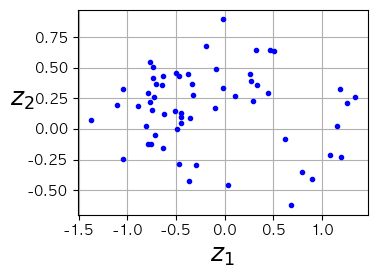

In [9]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [20]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [23]:
tf.random.set_seed(42)

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
# stacked_ae.compile(loss="binary_crossentropy",
#                    optimizer=tf.keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0975 - val_loss: 0.0443
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.1597 - val_loss: 0.0455
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.1741 - val_loss: 0.0501
Epoch 4/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0612 - val_loss: 0.0644
Epoch 5/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.1256 - val_loss: 0.0463
Epoch 6/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1465 - val_loss: 0.0302
Epoch 7/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.1325 - val_loss: 0.0993
Epoch 8/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.1645 - val_loss: 0.0560
Epoch 9/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.2131 - val_loss: 0.0896
Epoch 10/10
1719/1719 [==============================] - 21s 12m

1/1 [==============================] - 0s 41ms/step


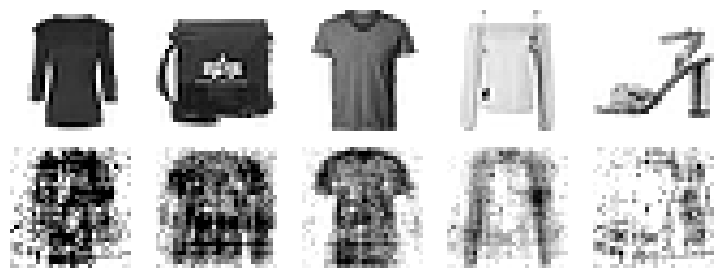

In [25]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")
plt.show()

In [27]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 847us/step


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [24]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"), position,
            bboxprops={'degecolor': cmap(y_valid[index]), "lw": 2}
        )
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

NameError: name 'X_valid_2D' is not defined

<Figure size 1000x800 with 0 Axes>

In [33]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                     shape=self.dense.input_shape[-1],
                                     initializer="zeros")
        super().build(batch_input_shape)
    
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [34]:
tf.random.set_seed(42)

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0229 - val_loss: 0.0176
Epoch 2/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 3/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 5/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0160 - val_loss: 0.0170
Epoch 7/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 8/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0156 - val_loss: 0.0164
Epoch 9/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 10/10
1719/1719 [==============================] - 18s 11m

1/1 [==============================] - 0s 291ms/step


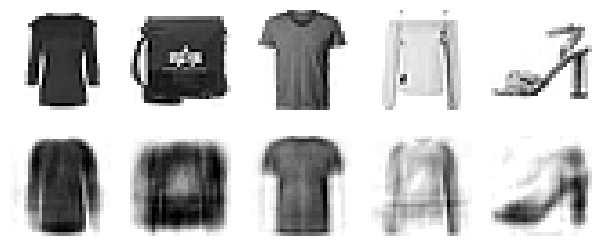

In [35]:
plot_reconstructions(tied_ae)
plt.show()

In [36]:
def trian_autoencoder(n_neurons, X_train, X_valid, n_epochs=10, output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [37]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = trian_autoencoder(
    100, X_train_flat, X_valid_flat
)
enc2, dec2, _, _ = trian_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu"
)

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0277 - val_loss: 0.0219
Epoch 2/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0159 - val_loss: 0.0170
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 6/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.0144 - val_loss: 0.0135
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 8/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0138 - val_loss: 0.0144
Epoch 9/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0137 - val_loss: 0.0159
Epoch 10/10
1719/1719 [==============================] - 16s 9ms/step - l

In [38]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 55ms/step


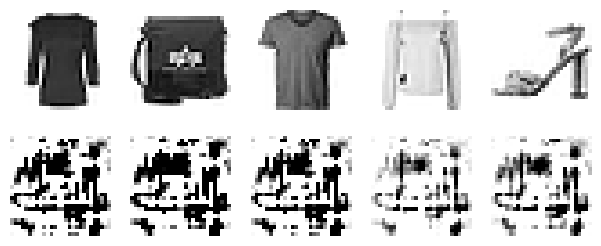

In [39]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [40]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0612 - val_loss: 0.0461
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0886 - val_loss: 0.0374
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.1508 - val_loss: 0.0590
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2129 - val_loss: 0.0955
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3538 - val_loss: 0.0417


1/1 [==============================] - 0s 37ms/step


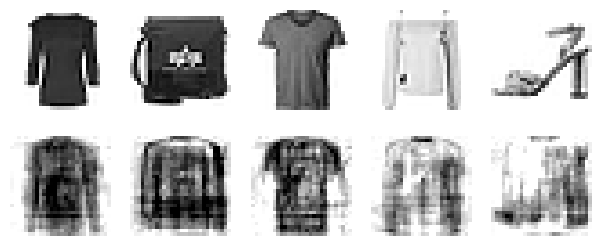

In [41]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [44]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 43s 23ms/step - loss: 0.0339 - val_loss: 0.0259
Epoch 2/10
1719/1719 [==============================] - 41s 24ms/step - loss: 0.0213 - val_loss: 0.0195
Epoch 3/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 4/10
1719/1719 [==============================] - 41s 24ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 5/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 6/10
1719/1719 [==============================] - 40s 24ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 7/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 41s 24ms/step - loss: 0.0129 - val_loss: 0.0141
Epoch 9/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 10/10
1719/1719 [==============================] - 40s 23m

1/1 [==============================] - 0s 421ms/step


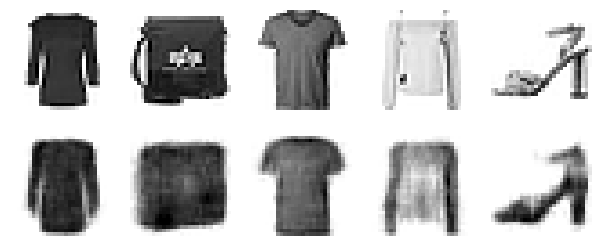

In [47]:
plot_reconstructions(conv_ae)
plt.show()

In [48]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [49]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 61s 33ms/step - loss: 0.0292 - val_loss: 0.0225
Epoch 2/10
1719/1719 [==============================] - 58s 34ms/step - loss: 0.0189 - val_loss: 0.0175
Epoch 3/10
1719/1719 [==============================] - 56s 32ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 4/10
1719/1719 [==============================] - 58s 33ms/step - loss: 0.0144 - val_loss: 0.0136
Epoch 5/10
1719/1719 [==============================] - 56s 33ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 6/10
1719/1719 [==============================] - 58s 34ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 7/10
1719/1719 [==============================] - 56s 33ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 8/10
1719/1719 [==============================] - 55s 32ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 9/10
1719/1719 [==============================] - 55s 32ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 10/10
1719/1719 [==============================] - 55s 32m

1/1 [==============================] - 1s 1s/step


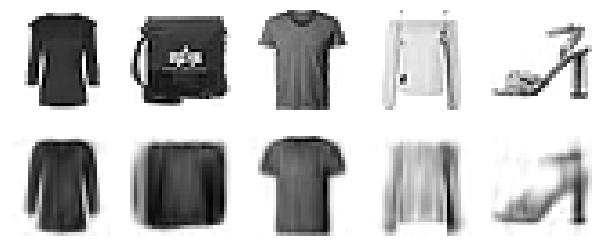

In [51]:
plot_reconstructions(recurrent_ae)
plt.show()

In [52]:
tf.random.set_seed(42)

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Dropout([28, 28]),
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


ValueError: in user code:

    File "/Users/kjs/miniconda3/envs/handson/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/kjs/miniconda3/envs/handson/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kjs/miniconda3/envs/handson/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/kjs/miniconda3/envs/handson/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/kjs/miniconda3/envs/handson/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'dropout_3' (type Dropout).
    
    `rate` must be a scalar or scalar tensor. Received: rate=ListWrapper([28, 28])
    
    Call arguments received by layer 'dropout_3' (type Dropout):
      • inputs=tf.Tensor(shape=(None, 784), dtype=float32)
      • training=True


1/1 [==============================] - 0s 192ms/step


TypeError: Invalid shape (784,) for image data

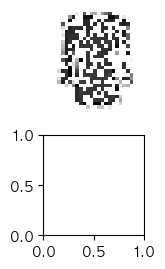

In [53]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

In [50]:
tf.random.set_seed(42)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 25s 14ms/step - loss: 0.0323 - val_loss: 0.0240
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0221 - val_loss: 0.0201
Epoch 3/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0226 - val_loss: 0.0188
Epoch 4/10
1719/1719 [==============================] - 25s 14ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 5/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 6/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.0191 - val_loss: 0.0184
Epoch 7/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 8/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 9/10
1719/1719 [==============================] - 25s 14ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 10/10
1719/1719 [==============================] - 24s 14m

1/1 [==============================] - 0s 56ms/step


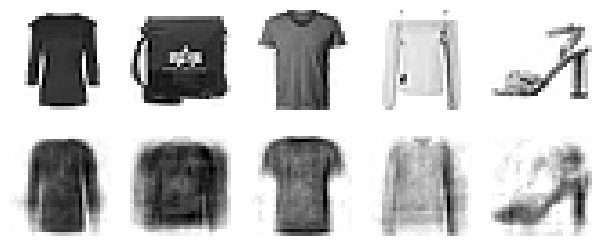

In [54]:
plot_reconstructions(sparse_l1_ae)
plt.show()

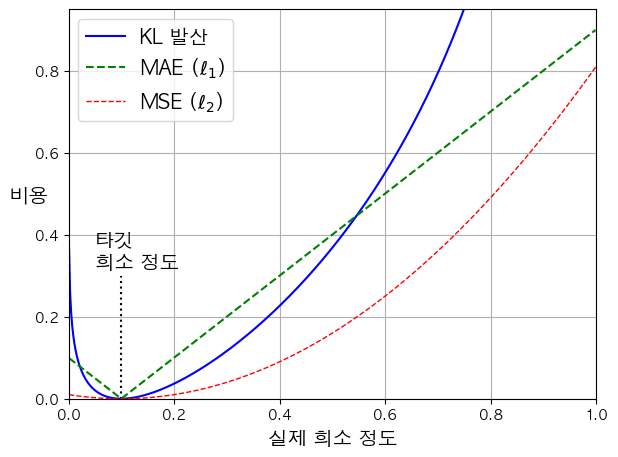

In [56]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "타깃\n희소 정도", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL 발산")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("실제 희소 정도")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

In [57]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [59]:
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.0302 - val_loss: 0.0218
Epoch 2/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.0207 - val_loss: 0.0190
Epoch 3/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 4/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.0175 - val_loss: 0.0171
Epoch 5/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 6/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.0168 - val_loss: 0.0173
Epoch 7/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.0168 - val_loss: 0.0175
Epoch 8/10
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0172 - val_loss: 0.0180
Epoch 9/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0178 - val_loss: 0.0184
Epoch 10/10
1719/1719 [==============================] - 30s 17m

1/1 [==============================] - 0s 61ms/step


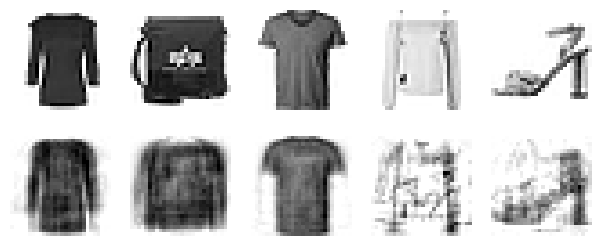

In [61]:
plot_reconstructions(sparse_kl_ae)
plt.show()

In [77]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [75]:
tf.random.set_seed(42)

codings_size= 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

In [76]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [78]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1
)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 13s 26ms/step - loss: 0.0769 - val_loss: 0.0814
Epoch 2/25
430/430 [==============================] - 10s 23ms/step - loss: 0.3523 - val_loss: 0.0745
Epoch 3/25
430/430 [==============================] - 10s 22ms/step - loss: 0.0694 - val_loss: 0.0712
Epoch 4/25
430/430 [==============================] - 10s 22ms/step - loss: 3313781748793344.0000 - val_loss: 134.0832
Epoch 5/25
430/430 [==============================] - 10s 23ms/step - loss: 199.4690 - val_loss: 137.5329
Epoch 6/25
430/430 [==============================] - 10s 23ms/step - loss: 101.8183 - val_loss: 65.0783
Epoch 7/25
430/430 [==============================] - 10s 23ms/step - loss: 83.2687 - val_loss: 77.0713
Epoch 8/25
430/430 [==============================] - 10s 23ms/step - loss: 70.5360 - val_loss: 60.9762
Epoch 9/25
430/430 [==============================] - 10s 23ms/step - loss: 40.6260 - val_loss: 28.3829
Epoch 10/25
430/430 [==============================]

1/1 [==============================] - 0s 101ms/step


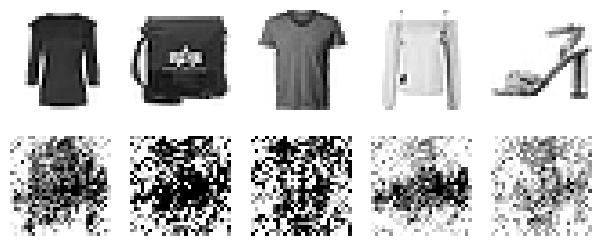

In [80]:
plot_reconstructions(variational_ae)
plt.show()

In [81]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 10), found shape=(21, 30)

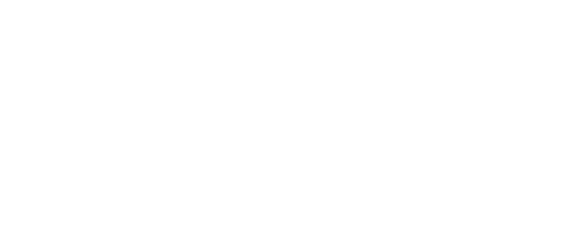

In [72]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

In [68]:
tf.random.set_seed(42)

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)
images = variational_decoder(codings).numpy()

In [69]:
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

NameError: name 'plot_multiple_images' is not defined

In [87]:
tf.random.set_seed(42)

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator =  tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [88]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [89]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

에포크 1/10


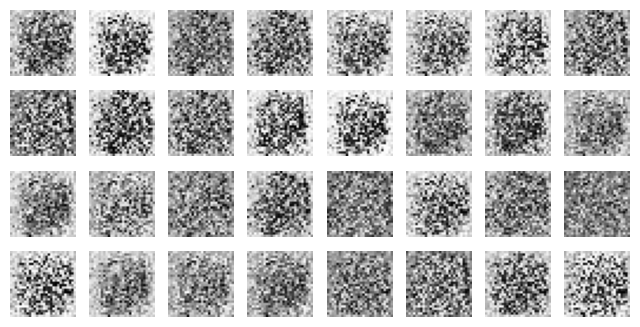

에포크 2/10


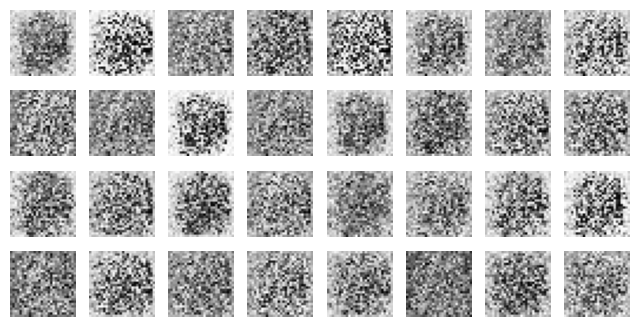

에포크 3/10


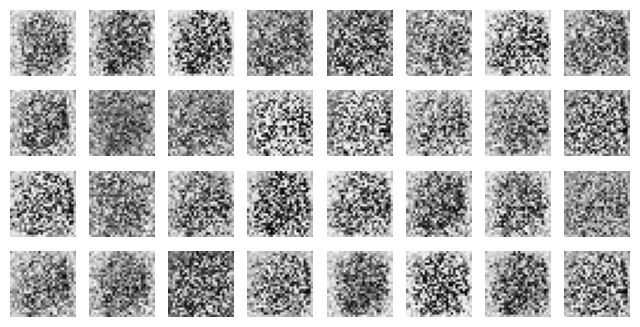

에포크 4/10


KeyboardInterrupt: 

In [90]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"에포크 {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 =tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [ ]:
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

In [91]:
tf.random.set_seed(42)

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", 
                                    activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", 
                                    activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [95]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [96]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. -1.

에포크 1/10


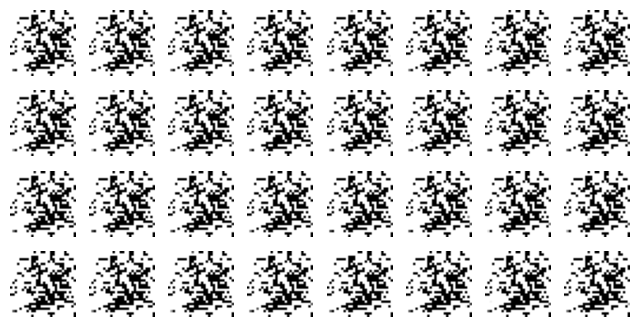

에포크 2/10


KeyboardInterrupt: 

In [97]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [ ]:
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

In [98]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 26s 14ms/step - loss: 0.0496 - val_loss: 0.1911
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0413 - val_loss: 0.1534
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0513 - val_loss: 0.0879
Epoch 4/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0604 - val_loss: 0.0791
Epoch 5/10
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0715 - val_loss: 0.0741
Epoch 6/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0770 - val_loss: 0.0761
Epoch 7/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0790 - val_loss: 0.0879
Epoch 8/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0815 - val_loss: 0.1615
Epoch 9/10
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0841 - val_loss: 0.0971
Epoch 10/10
1719/1719 [==============================] - 24s 14m

1/1 [==============================] - 0s 81ms/step


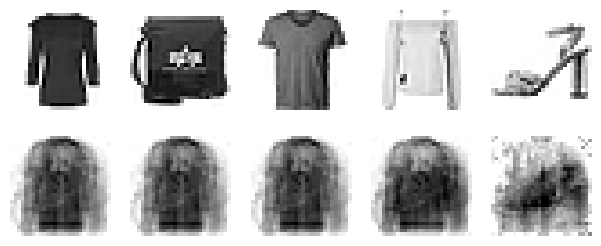

In [99]:
plot_reconstructions(hashing_ae)
plt.show()

In [100]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

157/157 [==============================] - 0s 1ms/step
1010111010100010
1010111010100010
1010111010100010
1010111010100010
1110101000100001
...


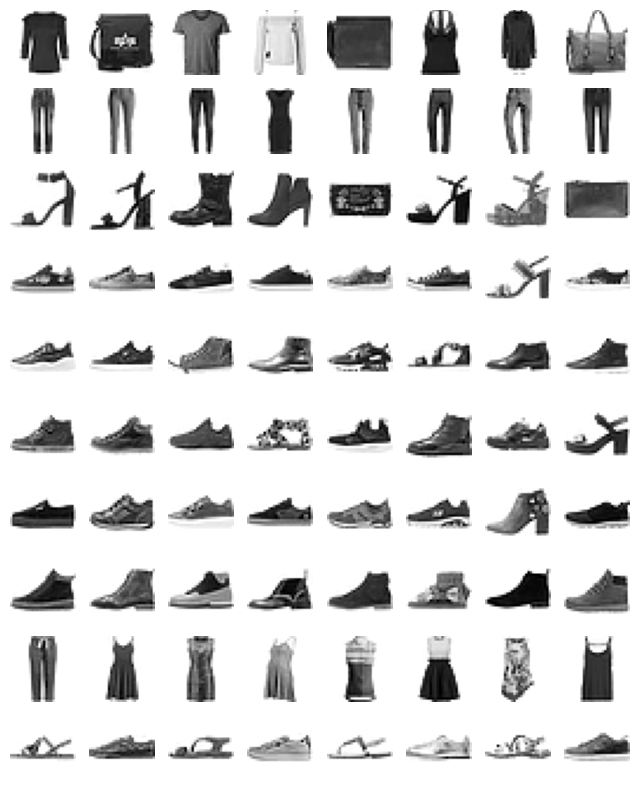

In [101]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()